The goal of this Jupyter notebook is to create a simple machine learning model that determines whether an image is a cat or dog. First, I manually resize the images for practice with working with images in Python. Then, using the train images, I create and train a model to make predictions on whether the test images contain a cat or a dog. The notebook concludes with a sumamry of results from the models predictions. 

In [46]:
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import cv2
import glob
import os

To better understand the dataset, we will output two random photos from the training set, noticing that the photos are different sizes. In order to use a neural network, we require that the photos be the same size. 

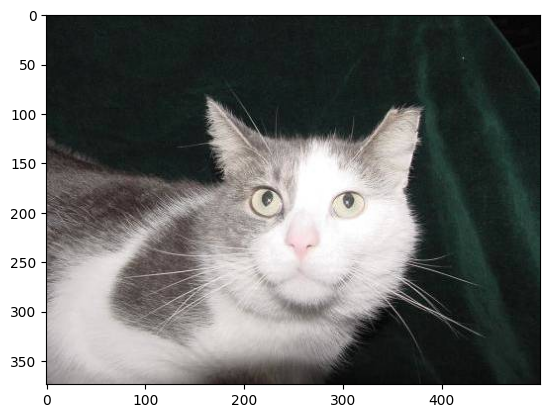

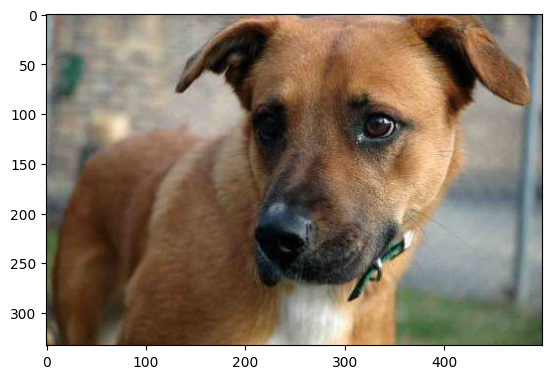

In [47]:
# display sample cat image
img = mpimg.imread('photos/train/cat.9812.jpg')
imgplt = plt.imshow(img)
plt.show()

# display sample dog image
img = mpimg.imread('photos/train/dog.2673.jpg')
imgplt = plt.imshow(img)
plt.show()

The following code determines the number of cat images and the number of dog images in the training dataset. 

In [48]:
# paths to photos
train_folder = 'photos/train'
test_folder = 'photos/test'

# count the number of cat and dog images
dog_count = 0
cat_count = 0
file_names = os.listdir(train_folder)
for img_file in file_names:
    name = img_file[0:3]
    if name == 'dog':
        dog_count += 1
    else:
        cat_count += 1

# print the counts
print('Number of dog images =', dog_count)
print('Number of cat images =', cat_count)


Number of dog images = 12500
Number of cat images = 12500


Creates a new folder to store resized photos 224x224.

In [49]:
# Creates folder for resized images
resized_folder = 'photos_resized'
os.makedirs(resized_folder, exist_ok=True)

# Resizes the photo and saves to new folder
# for img_file in file_names:
#     img_path = os.path.join(train_folder, img_file)

#     img = Image.open(img_path)
#     img = img.resize((224, 224))
#     img = img.convert('RGB')

#     new_img_path = os.path.join(resized_folder, img_file)
#     img = img.save(new_img_path)

Displays the previous cat and dog photo but resized to the standards. 

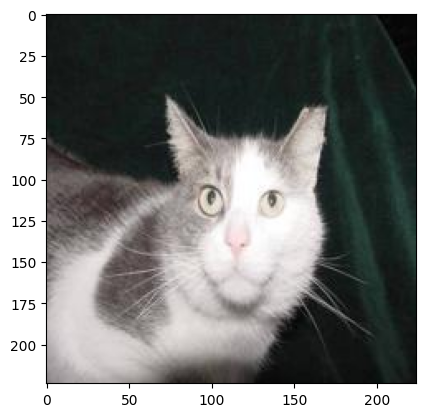

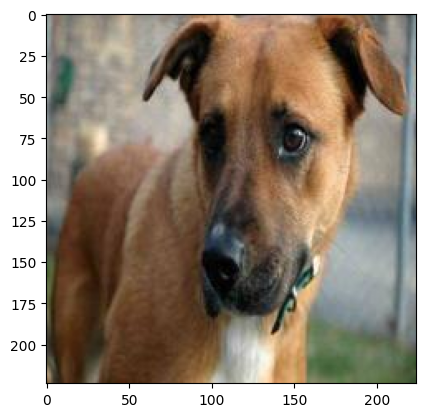

In [50]:
# display resized cat image
img = mpimg.imread('photos_resized/cat.9812.jpg')
imgplt = plt.imshow(img)
plt.show()

# display resized dog image
img = mpimg.imread('photos_resized/dog.2673.jpg')
imgplt = plt.imshow(img)
plt.show()

Creates a dataframe with the file names from the train folder and the corresponding categories (cat and dog).

In [51]:
categories = []
for img_file in file_names:
    category = img_file[0:3]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': file_names,
    'category': categories
})

Creates the model to be trained with the training images to make predictions on whether an image is a cat or a dog. 

In [52]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3

model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

Prints a summary of the model and its features. 

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 64)      

Callbacks and learning to improve the model.

In [54]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

Data to be used while training the model. 

In [55]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

Training and validating data to be used while training the model. 

In [56]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_folder,
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_folder, 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)
test_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
test_generator = train_datagen.flow_from_dataframe(
    validate_df,
    test_folder,
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 0 classes.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 5000 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Trains the model for 10 epochs. 

In [57]:
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 202s 151ms/step - loss: 0.7529 - accuracy: 0.6330 - val_loss: 0.6099 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 203s 152ms/step - loss: 0.5683 - accuracy: 0.7123 - val_loss: 0.6601 - val_accuracy: 0.6609 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 207s 155ms/step - loss: 0.5158 - accuracy: 0.7535 - val_loss: 0.4391 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 211s 158ms/step - loss: 0.4742 - accuracy: 0.7824 - val_loss: 0.4859 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 209s 156ms/step - loss: 0.4514 - accuracy: 0.7931 - val_loss: 0.3880 - val_accuracy: 0.8274 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 208s 156ms/step - loss: 0.4281 - accuracy: 0.8050 - val_loss: 0.3335 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 7/10
1333/1333 [============

Saves the model to be used in the future. 

In [58]:
model.save('models/model2_CatDog_10epoch.h5')

Prepares the data to be used for testing the model on the test images. 

In [59]:
test_filenames = os.listdir("photos/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

Uses the model to make predictions on whether the test images are cats or dogs. 

In [61]:
saved_model = load_model('models/model2_CatDog_10epoch.h5')
predict = saved_model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

ValueError: Asked to retrieve element 0, but the Sequence has length 0

Converts the labels used by the model back to the categoriese for data visualization.

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

NameError: name 'predict' is not defined

Shows the results of the preditions made by the model. 

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./dogs-vs-cats/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

KeyError: 'category'

<Figure size 1200x2400 with 0 Axes>